In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from data_generators.standard_generator import StandardDataGenerator
from environments.contextual_environment import ContextualEnvironment
from learners.pricing.contextual_learner import ContextualLearner
from learners.pricing.thompson_sampling import ThompsonSampling
from learners.pricing.ucb import UCB
from utils.context_generator import ContextGenerator 

__DEFINITION OF ALL THE PARAMETERS__ 

In [2]:
# data
data_src = 'src/basicCG.json'
sel_bid = 3
dg = StandardDataGenerator(filename=data_src)

# simulation
T = 365
n_experiments = 10
learners_to_test = [ThompsonSampling]
features = dg.get_features() 
fractions = dg.get_class_distributions(sel_bid)
bandit_args = {
            'arm_values': dg.get_margins()
}
env_args = {
    'bid_idx': sel_bid,
    'mode': 'all',
    'src': dg.get_source(),
    'generator': 'standard'
}

# context generator
cg_start_from = 31
cg_confidence = 0.2
cg_frequency = 10

__ACTUAL SOURCE DATA__

In [3]:
prices = dg.get_prices()
bids = dg.get_bids()
categories = list(dg.get_classes().keys())

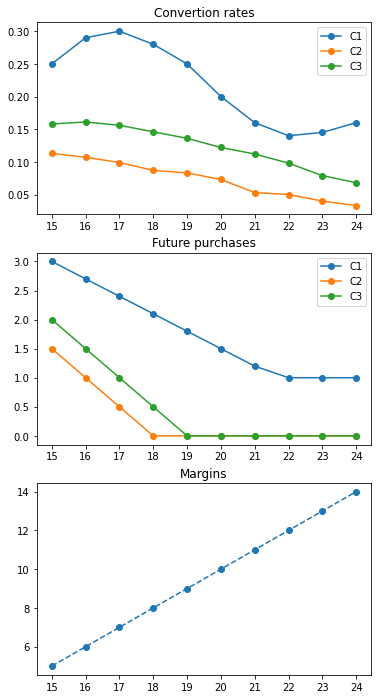

In [4]:
fig, axs = plt.subplots(3, 1, figsize=(6,12))
#plt.setp(axs, xticks=prices)

# plot 1: Covnersion rates
conv_rates = dg.get_conversion_rates()
axs[0].set_xticks(prices)
for i in range(0,len(conv_rates)):
    axs[0].plot(prices, conv_rates[i], '-o', label=categories[i])
    
axs[0].legend(loc='best')
axs[0].set_title("Convertion rates");

# plot 2: Future Purchases
axs[1].set_xticks(prices)
next_purch = dg.get_future_purchases()
axs[1].set_xticks(prices)
for i in range(0,len(next_purch)):
    axs[1].plot(prices, next_purch[i], '-o', label=categories[i])
    
axs[1].legend(loc='best')
axs[1].set_title("Future purchases");

# plot 3: Margins
axs[2].set_xticks(prices)
margins = dg.get_margins()
axs[2].set_xticks(prices)
axs[2].plot(prices, margins, '--o')
axs[2].set_title("Margins");

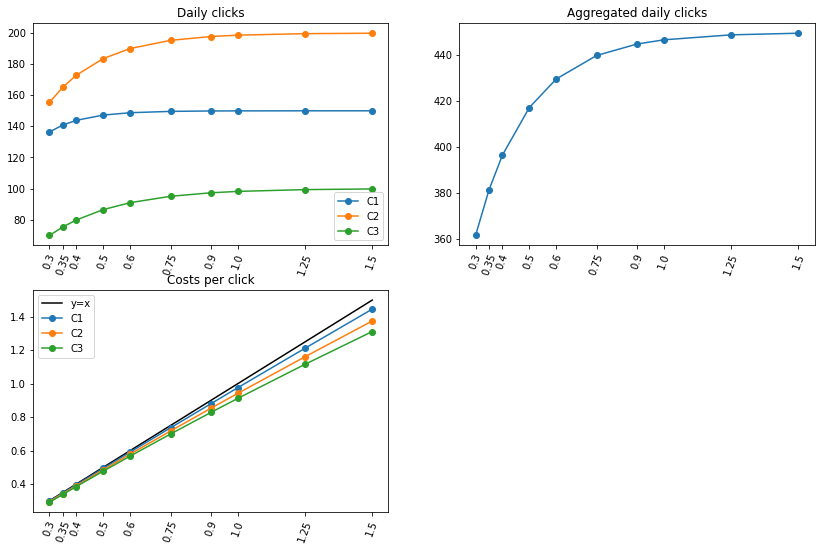

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(14, 9))
#plt.setp(axs, xticks=prices)

# plot 1: Daily clicks
daily_clicks = dg.get_daily_clicks()
axs[0,0].set_xticks(bids)
axs[0,0].set_xticklabels(bids, rotation=70)
for i in range(0,len(daily_clicks)):
    axs[0,0].plot(bids, daily_clicks[i], '-o', label=categories[i])
axs[0,0].legend(loc='best')
axs[0,0].set_title("Daily clicks");

# plot 2: aggr_daily clicks
aggr_daily_click = dg.get_daily_clicks(mode='aggregate')
axs[0,1].set_xticks(bids)
axs[0,1].set_xticklabels(bids, rotation=70)
axs[0,1].plot(bids, aggr_daily_click, '-o')
axs[0,1].set_title("Aggregated daily clicks");

# plot 3: Cost per click
costs = dg.get_costs_per_click()
axs[1,0].set_xticks(bids)
axs[1,0].set_xticklabels(bids, rotation=70)
axs[1,0].plot(bids,bids, color='black', label="y=x")
for i in range(0,len(costs)):
    axs[1,0].plot(bids, costs[i], '-o', label=categories[i])
axs[1,0].legend(loc='best')
axs[1,0].set_title("Costs per click");

axs[1,1].set_axis_off()

In [6]:
print('OPTIMAL VALUES PER BID')
print('\nbid\tglobal\t\tr_aggr\t\t\tdelta')
for j, bid in enumerate(dg.get_bids()):
    maxs=[]
    cost = dg.get_costs_per_click(mode='aggregate', bid=j)[j]
    clicks = dg.get_daily_clicks(mode='aggregate')[j]
    conv = dg.get_conversion_rates()
    fp = dg.get_future_purchases()
    for i in range(len(dg.get_classes())):
        maxs.append(np.max((conv[i] *(1 + fp[i]) * dg.get_margins() - cost) * dg.get_daily_clicks()[i, j]))
    
    temp = (dg.get_margins() * np.average(conv * (1 + fp), axis=0, weights=dg.get_class_distributions(bid=j)) - 
        cost) * clicks
    disaggr = np.around(sum(maxs), decimals=4)
    aggr = np.around(np.max(temp), decimals=4)
    delta = np.around(disaggr-aggr, decimals=4)
    print(f'{j}\t{disaggr}\t{aggr}\t-->\t{delta}')

OPTIMAL VALUES PER BID

bid	global		r_aggr			delta
0	1255.3814	1181.2844	-->	74.097
1	1290.3818	1211.345	-->	79.0368
2	1309.2731	1226.333	-->	82.9401
3	1316.704	1228.2539	-->	88.4501
4	1300.9686	1209.0754	-->	91.8932
5	1256.9148	1162.1222	-->	94.7926
6	1203.1555	1106.9154	-->	96.2401
7	1165.2235	1068.4519	-->	96.7716
8	1068.4233	971.023	-->	97.4003
9	971.4858	873.8864	-->	97.5994


---
__SIMULATION__

In [7]:
rewards_per_experiment = {}
context_split_per_experiment = {}
#days_of_split = {}
for learner in learners_to_test:
    rewards_per_experiment[learner.LEARNER_NAME] = []
    context_split_per_experiment[learner.LEARNER_NAME] = []
    #days_of_split[learner.LEARNER_NAME] = []

In [8]:
for e in range(n_experiments):
    print(f'\n\nrunning experiment {e + 1}/{n_experiments}...')
    test_instances = []
    
    for learner in learners_to_test:
        context_learner = ContextualLearner(features, learner, **bandit_args)
        test_instances.append(
            (context_learner,
             ContextualEnvironment(**env_args),
             ContextGenerator(features=features,
                              contextual_learner=context_learner,
                              update_frequency=cg_frequency,
                              start_from=cg_start_from,
                              confidence=cg_confidence,
                              verbose=0))
        )
    for t in range(T):
        for context_learner, env, context_generator in test_instances:
            #print(f'##### DAY {t} ######')
            context_learner.next_day()
            past_arms = env.get_selected_arms_at_day(t - 30, keep=False, filter_purchases=True)
            past_features = env.get_collected_user_features_at_day(t - 30, keep=False, filter_purchases=True)
            month_purchases = env.get_next_purchases_at_day(t, keep=True, filter_purchases=True)
            if month_purchases is not None:
                context_learner.update_next_purchases(past_arms, month_purchases, past_features)

            pulled_arms = context_learner.pull_arms()
            daily_rewards = env.day_round(pulled_arms)
            daily_users_features = env.get_collected_user_features_at_day(t)
            daily_pulled_arms = env.get_selected_arms_at_day(t)
            
            context_learner.update(daily_rewards, daily_pulled_arms, daily_users_features)
            context_generator.collect_daily_data(daily_pulled_arms, 
                                                 daily_rewards, 
                                                 daily_users_features,
                                                 next_purchases=month_purchases, 
                                                 past_pulled_arms=past_arms,
                                                 past_features=past_features)
    for learner, _, _ in test_instances:
        learner.next_day()
        rewards_per_experiment[learner.base_learner_class.LEARNER_NAME].append(learner.get_daily_rewards())
        context_split_per_experiment[learner.base_learner_class.LEARNER_NAME].append(learner.get_splits_count())
        #days_of_split[learner.base_learner_class.LEARNER_NAME].append(context_generator.metadata['SPLIT_DAYS'])



running experiment 1/10...


running experiment 2/10...


running experiment 3/10...


running experiment 4/10...


running experiment 5/10...


running experiment 6/10...


running experiment 7/10...


running experiment 8/10...


running experiment 9/10...


running experiment 10/10...


In [9]:
margins = dg.get_margins()
classes = dg.get_classes()
conversion_rates = dg.get_conversion_rates(mode='all')
future_purchases = dg.get_future_purchases(mode='all')
number_of_clicks = dg.get_daily_clicks(mode='all')
costs_per_click = dg.get_costs_per_click(mode='aggregate', bid=sel_bid)
fixed_cost = costs_per_click[sel_bid]
fixed_n_clicks = np.rint(dg.get_daily_clicks(mode='aggregate')[sel_bid]).astype(int)
fractions = dg.get_class_distributions(sel_bid)

temp = (margins * np.average(conversion_rates * (1 + future_purchases),
                             axis=0,
                             weights=fractions) - fixed_cost) * fixed_n_clicks
aggr_opt_arm = np.argmax(temp)
aggr_opt = np.max(temp)

disaggr_opt = 0
opt_arms = []
for i, _ in enumerate(conversion_rates):
    t = (margins * conversion_rates[i] * (1 + future_purchases[i]) - fixed_cost) * \
                number_of_clicks[i, sel_bid]
    opt_arm = np.argmax(t)
    opt_value = np.max(t)
    opt_arms.append(opt_arm)
    disaggr_opt += opt_value

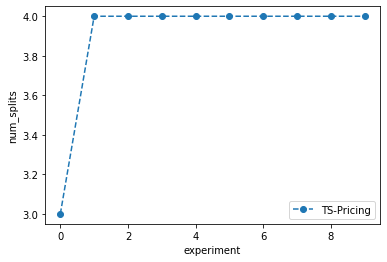

In [10]:
plt.figure()
plt.ylabel("num_splits")
plt.xlabel("experiment")
for val in context_split_per_experiment.values():
    plt.plot(val, '--o')
plt.legend(context_split_per_experiment.keys())
plt.show()

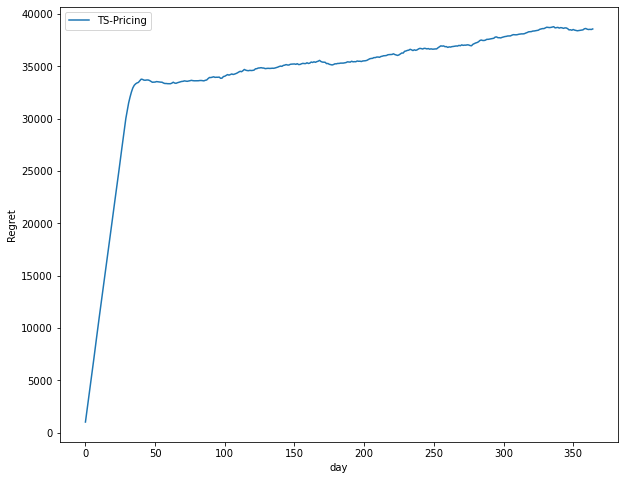

In [11]:
# Plotting the results
plt.figure(figsize=(10,8))
plt.ylabel("Regret")
plt.xlabel("day")
for val in rewards_per_experiment.values():
    plt.plot(np.cumsum(np.mean(disaggr_opt - val, axis=0)))

#plt.axvline(x=cg_start_from, color='r', linestyle='--')
#for val in days_of_split.values():
#    avg_days = np.mean(val, axis=0)
#    for day in avg_days:
#        plt.axvline(x=day, color='m', linestyle='--')

plt.legend(rewards_per_experiment.keys())
plt.show()

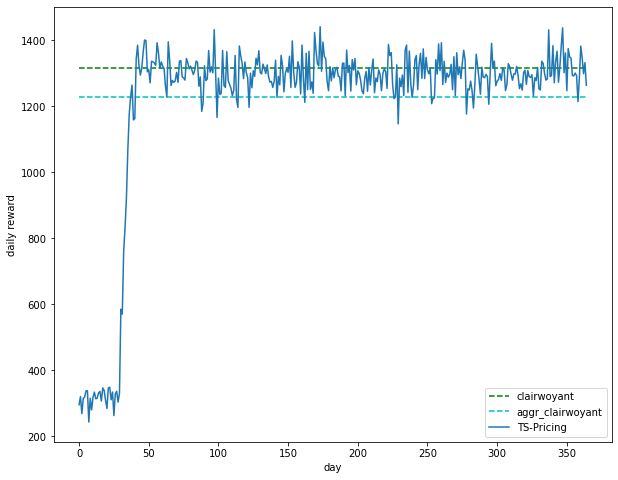

In [12]:
plt.figure(figsize=(10,8))
plt.xlabel("day")
plt.ylabel("daily reward")
plt.plot([disaggr_opt]*T, '--g', label='clairwoyant')
plt.plot([aggr_opt]*T, '--c', label='aggr_clairwoyant')
for key in rewards_per_experiment:
    plt.plot(np.mean(rewards_per_experiment[key], axis=0), label=key)

#plt.axvline(x=cg_start_from, color='r', linestyle='--')
#for val in days_of_split.values():
#    avg_days = np.mean(val, axis=0)
#    for day in avg_days:
#        plt.axvline(x=day, color='m', linestyle='--')

plt.legend(loc='best')
plt.show()